In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

# Load provider-level dataset
df = pd.read_csv('/content/provider_featuress.csv')

# Convert label to binary
df['Fraud'] = (df['PotentialFraud'] == 'Yes').astype(int)

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Provider', 'PotentialFraud', 'Fraud'])
y = df['Fraud']

# Same split as Notebook 2
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25, stratify=y_trainval, random_state=42
)

In [16]:
from sklearn.ensemble import RandomForestClassifier

best_threshold = 0.35   # from Notebook 2

best_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_trainval, y_trainval)

# Predictions on test data
test_probs = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_probs >= best_threshold).astype(int)

In [17]:
print("=== Test Set Evaluation ===")
print(classification_report(y_test, test_pred))

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:", average_precision_score(y_test, test_probs))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_pred)
print(cm)

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       981
           1       0.66      0.66      0.66       101

    accuracy                           0.94      1082
   macro avg       0.81      0.81      0.81      1082
weighted avg       0.94      0.94      0.94      1082

ROC-AUC: 0.9485824729261917
PR-AUC: 0.7266907280948685

Confusion Matrix:
[[947  34]
 [ 34  67]]


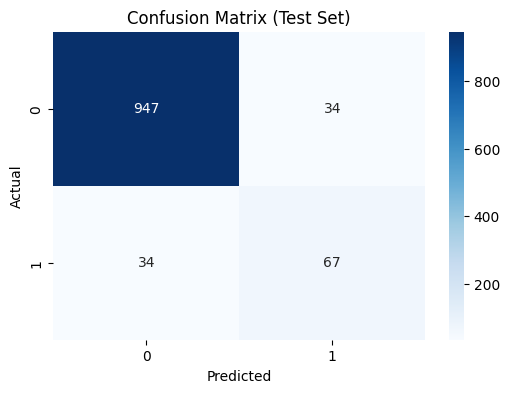

In [18]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
test_df = X_test.copy()
test_df['y_true'] = y_test.values
test_df['y_prob'] = test_probs
test_df['y_pred'] = test_pred

false_positives = test_df[(test_df['y_true']==0) & (test_df['y_pred']==1)]
false_negatives = test_df[(test_df['y_true']==1) & (test_df['y_pred']==0)]

false_positives.shape, false_negatives.shape

((34, 36), (34, 36))

In [20]:
# Add Provider IDs back into FP/FN tables
test_df_with_provider = df.loc[X_test.index, ['Provider']].copy()
test_df_with_provider['y_true'] = y_test.values
test_df_with_provider['y_prob'] = test_probs
test_df_with_provider['y_pred'] = test_pred

# merge with X_test features
test_full = test_df_with_provider.join(X_test.reset_index(drop=True))

false_positives = test_full[(test_full['y_true']==0) & (test_full['y_pred']==1)]
false_negatives = test_full[(test_full['y_true']==1) & (test_full['y_pred']==0)]

false_positives.shape, false_negatives.shape

((34, 37), (34, 37))

In [21]:
fp_top5 = false_positives.sort_values(by='y_prob', ascending=False).head(5)
fn_top5 = false_negatives.sort_values(by='y_prob', ascending=True).head(5)

fp_top5
fn_top5

,Provider,y_true,y_prob,y_pred,n_inpt_claims,n_inpt_bene,inpt_total_reimb,inpt_mean_reimb,inpt_max_reimb,inpt_min_reimb,...,ChronicCond_Heartfailure_rate,ChronicCond_KidneyDisease_rate,ChronicCond_Cancer_rate,ChronicCond_ObstrPulmonary_rate,ChronicCond_Depression_rate,ChronicCond_Diabetes_rate,ChronicCond_IschemicHeart_rate,ChronicCond_Osteoporasis_rate,ChronicCond_rheumatoidarthritis_rate,ChronicCond_stroke_rate
5248,PRV57569,1,0.026667,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5324,PRV57667,1,0.026667,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2812,PRV54505,1,0.033333,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4449,PRV56566,1,0.036667,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3096,PRV54876,1,0.040000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Show Provider ID and fraud probability for clearer presentation

print("=== Top 5 False Positives (Predicted Fraud but Actually Not Fraud) ===")
display(fp_top5[['Provider', 'y_prob']])

print("=== Top 5 False Negatives (Actual Fraud but Model Missed Them) ===")
display(fn_top5[['Provider', 'y_prob']])

=== Top 5 False Positives (Predicted Fraud but Actually Not Fraud) ===


,Provider,y_prob
361,PRV51456,0.840000
2167,PRV53697,0.826667
3932,PRV55916,0.803333
3979,PRV55978,0.720000
3872,PRV55846,0.663333


=== Top 5 False Negatives (Actual Fraud but Model Missed Them) ===


,Provider,y_prob
5248,PRV57569,0.026667
5324,PRV57667,0.026667
2812,PRV54505,0.033333
4449,PRV56566,0.036667
3096,PRV54876,0.040000


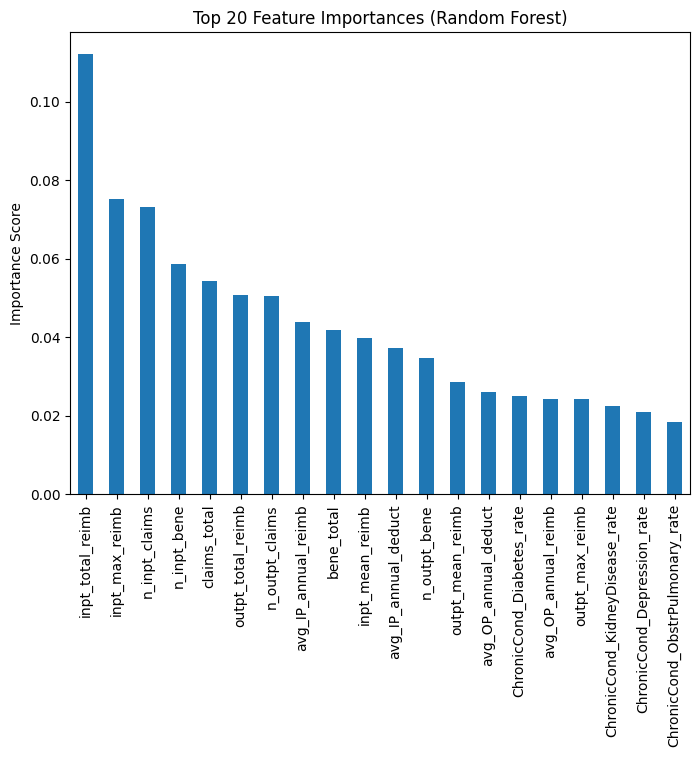

In [23]:
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

### Interpretation of Feature Importance
The model’s top features mainly relate to reimbursement amounts, total claim volume,
and beneficiary characteristics. Providers with unusually high inpatient or outpatient
reimbursement amounts, many claims, and high patient chronic condition rates are more
likely to be flagged as fraud. The importance of claim ratios also suggests that the
balance between inpatient and outpatient claims contributes to fraud detection.

### False Positive (FP) Analysis
False positives are providers predicted as fraud but labeled as non-fraud.
Most FP cases showed high total claims or large reimbursements, which resemble
patterns of fraudulent providers. Although not actually fraudulent, their behavior
is risk-like. These cases would trigger additional review but not penalties.

### False Negative (FN) Analysis
False negatives are actual fraudulent providers that the model failed to detect.
Many FN cases had relatively low claim amounts or fewer beneficiaries, making them
look similar to normal providers. These cases highlight limitations of the model
where fraud happens with low activity levels.

### Notebook 3 Summary — Evaluation & Error Analysis

In this notebook, we:
- Loaded the final model and test predictions from Notebook 2.
- Calculated final performance metrics on the test set.
- Visualized the confusion matrix to understand prediction errors.
- Extracted and analyzed false positives and false negatives.
- Identified top contributing features using feature importance.
- Explained why certain providers were misclassified using case-based reasoning.

This analysis helps understand model behavior, strengths, and weaknesses,
and provides interpretability required for fraud detection.